# Webscrape Righmove
Goal: Collect data on all the listings in nottingham and create a color coordinated map of rent accross the city


In [1]:
#Import Libraries
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

import pandas as pd
import time

from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from selenium.webdriver.common.keys import Keys

In [3]:
#open url
url = 'https://www.rightmove.co.uk/'
#create driver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get(url)

#Allow Cookies
driver.find_element(By.XPATH,"/html/body/div[1]/div[2]/div[4]/div[2]/div/button").send_keys(Keys.ENTER)

[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 6.78M/6.78M [00:01<00:00, 6.37MB/s]


In [4]:
# navigate to houses in nottingham
city = 'Nottingham'
driver.find_element(By.NAME,"typeAheadInputField").send_keys(city,Keys.RETURN)

### Logic and Understanding

I want data on all houses/flats for sale 

I want to scrape the data change page and repeat

In [5]:
#find properties btn
driver.find_element(By.CSS_SELECTOR,'button.touchsearch-button.touchsearch-primarybutton').click()

**The logic works !!!**
- Change the page then use driver.page_source to download the source code

### 1. Scrape the html from every page
- Dynamic Webscraping


In [5]:
#build logic

#Get Number of pages
total_pages = driver.find_element(By.XPATH,'//*[@id="l-container"]/div[3]/div/div/div/div[2]/span[3]').text

broth = []

for i in range(0,int(total_pages)):    
    
    time.sleep(1)
    
    #get html
    page_i = driver.page_source
    
    #create soup (turn html into a parsable text)
    soup = BeautifulSoup(page_i, 'html.parser')
    broth.append(soup)
    
    #explicit wait -  wait for the next page to load
    wait =  WebDriverWait(driver,10)
    wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR,'button.pagination-button.pagination-direction.pagination-direction--next')))
    
    #click next page btn
    driver.find_element(By.CSS_SELECTOR,'button.pagination-button.pagination-direction.pagination-direction--next').click()
    
    #repeat

#### Confirm it works

In [6]:
len(broth)

42

Have we scraped them all?

- There is approx 25 listing on each page and 42 pages so we are expecting 1050 listings. **Confirmed**

In [7]:
addresses = [x.text for i in broth for x in i.find_all('address') ]
len(addresses)

1050

#### To do next
- Create a table and impute the data
- Scrape the price data

Bonus
- Find extra features of houses we can use

. Bathroom / Bedrooms

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
table = pd.DataFrame(columns = ['Address'],data = addresses)

In [10]:
table.head()

,Address
0,"Upper Parliament Street, Nottingham, NG1 2AP"
1,STUDENT PROPERTY NOTTINGHAM CITY CENTER
2,"Fairmont, Edwalton"
3,"Fairmont, Edwalton"
4,"North Sherwood street, Nottingham"


II . Scrape price data

In [47]:
#format the guide price
guide_prices_str = [x.text  for i in broth for x in i.find_all('div',{'class':'propertyCard-priceValue'})  ]
pp1 = [i.replace('£','') for i in guide_prices_str]
guide_prices = [i.replace(',','') for i in pp1]
table['guide_price'] = guide_prices

#sort out POA values
table[table['guide_price']=='POA'] = np.nan
table['guide_price'] = table['guide_price'].astype(float)

Quick insight break

In [12]:
import matplotlib.ticker as ticker
import numpy as np

In [41]:
#Change guide price to int
temp_df = table.drop(table[table['guide_price']=='POA'].index)
temp_df['guide_price'] = temp_df['guide_price'].astype(int)
temp_df.dtypes

Address        object
guide_price     int32
dtype: object

In [14]:
temp_df['guide_price_log'] = np.log(temp_df['guide_price'])


Text(0.5, 1.0, 'Index vs Guide Price')

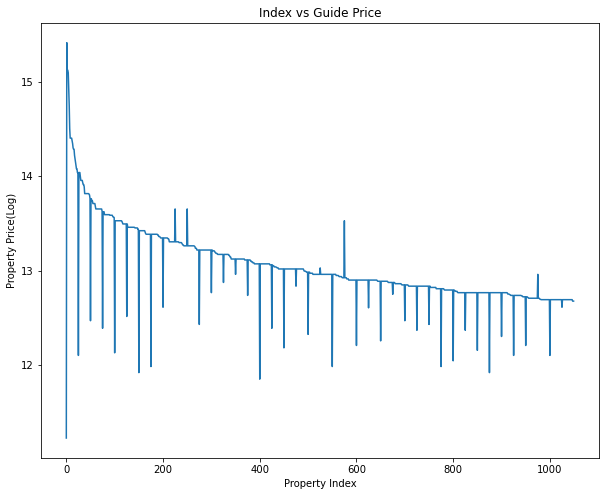

In [15]:
fig = plt.figure(figsize=(10,8))

plt.plot(temp_df.index,temp_df['guide_price_log'])

#label
plt.xlabel('Property Index')
plt.ylabel('Property Price(Log)')
plt.title('Index vs Guide Price')

**III**. Get number of Bathrooms and Bedrooms

In [16]:
broth[0].select('.no-svg-bathroom-icon.bathroom-icon.seperator')[0].text

'1 bathroom'

Problem encountered

- There were some cards with missing values therefore we needed to know which ones were missing and learn how to use next child method

*** To Do ***


Gather data on 
- Bed
- Bathroom
- House type

keep track of what values belong to which property

### 2. Scrape the features

In [32]:
address = []
house_type = []
bedrooms = []
bathrooms = []

#create dataframe to hold the 
data = pd.DataFrame(columns = ['address','house_type','bedrooms','bathrooms'])

for i,soup in enumerate(broth):
    
    #get the property info objects from each page
    prop_info = soup.find_all('div',{'class':'property-information'})
    
    #Loop through each property info object and gater the addy + info
    for x in prop_info:
        
        #go up one node to get the address
        address.append(x.previous_sibling.text)
        
        #descend 1 node to get to the house type, number of bathrooms and beds
        house_type.append(x.find_all('span')[0].text)
        
        
        #When ther isnt a value for beds of bathrooms append a nan value
        try:
            bedrooms.append(x.find_all('span')[1].text[0])
        except:
            bedrooms.append(np.nan)
            
        try:
            bathrooms.append(x.find_all('span')[2].text[0])
        except:
            bathrooms.append(np.nan)
            
# add data to dataframe

data['address'],data['house_type'],data['bedrooms'],data['bathrooms']=[address,house_type,bedrooms,bathrooms]

In [49]:
data['guide_price'] = table['guide_price']
data.head()

,address,house_type,bedrooms,bathrooms,guide_price
0,"Upper Parliament Street, Nottingham, NG1 2AP",Flat,1,1,75000.0
1,STUDENT PROPERTY NOTTINGHAM CITY CENTER,House Share,5,5,4950000.0
2,"Fairmont, Edwalton",Detached,5,5,3700000.0
3,"Fairmont, Edwalton",Detached,5,5,3700000.0
4,"North Sherwood street, Nottingham",House Share,4,4,3600000.0


### This is Sexual!!

In [50]:
#Export the table 
data.to_csv('rightmove_data',index = False)

In [51]:
pd.read_csv('rightmove_data')

,address,house_type,bedrooms,bathrooms,guide_price
0,"Upper Parliament Street, Nottingham, NG1 2AP",Flat,1.0,1.0,75000.0
1,STUDENT PROPERTY NOTTINGHAM CITY CENTER,House Share,5.0,5.0,4950000.0
2,"Fairmont, Edwalton",Detached,5.0,5.0,3700000.0
3,"Fairmont, Edwalton",Detached,5.0,5.0,3700000.0
4,"North Sherwood street, Nottingham",House Share,4.0,4.0,3600000.0
...,...,...,...,...,...
1045,"Wilne Road, Sawley",Cottage,3.0,3.0,325000.0
1046,"Park Road,\r\nCalverton,\r\nNottingham,\r\nNG1...",Detached,4.0,4.0,324995.0
1047,"Hampton Close, Toton",Detached Bungalow,3.0,3.0,320000.0
1048,"(Plot 3) Block A, The Yacht Club, NG2",Apartment,2.0,2.0,320000.0


### Data set is now created !
- Follow up is to train a predictive model 
- Use geopandas to vizualize price and location